In [23]:
#!pip install statsmodels

In [24]:
#from google.colab import drive
#drive.mount('/content/drive')

# Time Series

## 4.2 BUILD HOLT-WINTERS EXPONENTIAL SMOOTHING MODEL

In this task, you are required to build a Holt-Winters exponential smoothing model on the bikesharing.csv dataset. The model should be able to capture historical data and predict future daily bike rental.
In order to verify the model accuracy, you should use data from 2011-01-01 to 2012-10-31 as your training data, and data from 2012-11-01 to 2012-12-31 as testing data.
Using Holt-Winters exponential smoothing model, your output should look similar to below:
(Hint: from statsmodels.tsa.holtwinters import ExponentialSmoothing)


https://otexts.com/fpp3/holt-winters.html


In [25]:
# load the dataset
#df = pd.read_csv('data/bikesharing.csv')
df = pd.read_csv(
    '/content/drive/MyDrive/Jupyter/JupyterIT8302new/data/bikesharing.csv')

df['dteday'] = pd.to_datetime(df['dteday'])
df.set_index('dteday', inplace=True)
# group and calculate daily rental
daily_rental = df.resample('D')[['cnt']].sum()
# define training and testing dataset
train_data = daily_rental[daily_rental.index<'2012-11']
test_data = daily_rental[daily_rental.index>='2012-11']

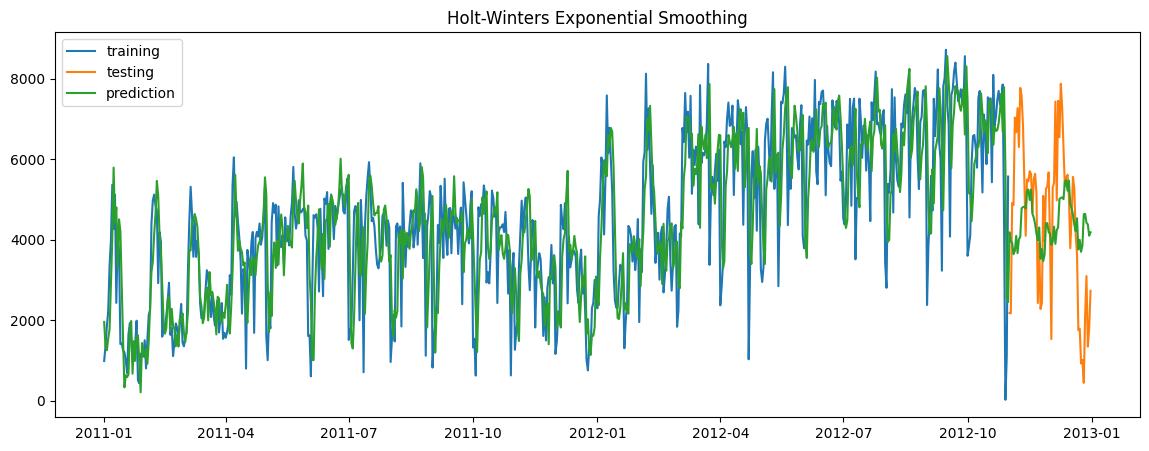

In [26]:
# Exponential Smoothing Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from sklearn.metrics import mean_absolute_percentage_error
es_model = HWES(train_data, seasonal_periods=28, trend='add', seasonal='add',
    damped_trend=False, freq='D').fit()
pred1 = es_model.predict(start='2011-01-01', end='2012-12-31')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

In [27]:
# Evaluation
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2012-11'])
mape_test = mean_absolute_percentage_error(test_data, pred1[pred1.index>='2012-11'])
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

Model Mean Absolute Percentage Error on training data is 69.85%
Model Mean Absolute Percentage Error on testing data is 61.87%


Recursive Multistep Forecasting

https://www.kaggle.com/code/ahmedabdulhamid/recursive-multistep-time-series-forecasting




* The model takes the initial input data and makes a prediction for the next time step (t+1).
* This prediction is then used to update the input data.
* The updated input is fed back into the model to predict the subsequent time step (t+2).
* The process continues, with each new prediction being used to update the input for the next prediction.


This recursive process allows the model to make predictions for multiple steps into the future


Key Points:


1.   Each prediction becomes part of the input for the next step
2.   Can capture complex dependencies across time steps
3.   Errors may accumulate over long forecast horizons


https://forecastegy.com/posts/multi-step-time-series-forecasting-in-python/

https://skforecast.org/0.14.0/examples/examples_english.html

https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.compose.RecursiveTimeSeriesRegressionForecaster.html

https://machinelearningmastery.com/multi-step-time-series-forecasting/




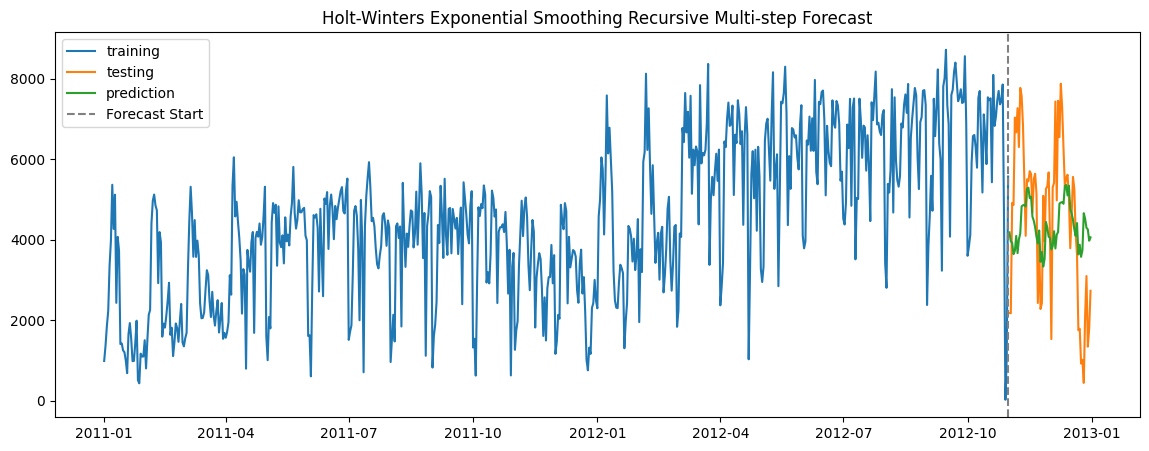

In [32]:
# Implementing a recursive forecast using python
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# load the dataset
#df = pd.read_csv('data/bikesharing.csv')
df = pd.read_csv(
    '/content/drive/MyDrive/Jupyter/JupyterIT8302new/data/bikesharing.csv')

df['dteday'] = pd.to_datetime(df['dteday'])
df.set_index('dteday', inplace=True)
# group and calculate daily rental
daily_rental = df.resample('D')[['cnt']].sum()
# define training and testing dataset
train_data = daily_rental[daily_rental.index<'2012-11']
test_data = daily_rental[daily_rental.index>='2012-11']

# We will use HWES as it runs a lot faster than the SARIMA model

# Fit Holt-Winters Exponential Smoothing model to the train_data
model = HWES(train_data, seasonal_periods=28, trend='add', seasonal='add',
    damped_trend=False, freq='D')
model_fit = model.fit()
# get the forecast within the training data horizon
pred1 = model_fit.predict(start='2011-01-01', end='2012-11-01')

# Recursive multi-step forecasting for the length of test_data
forecast_horizon = len(test_data)
history = train_data['cnt'].copy()  # Start with the training data
forecasts = pd.Series(dtype=float, name='Forecasts', index=pd.DatetimeIndex([]))

for t in range(forecast_horizon):
    model = HWES(history, seasonal_periods=28, trend='add', seasonal='add',
                damped_trend=False, freq='D')
    #model = HWES(history, trend='add', seasonal=None, seasonal_periods=None)
    model_fit = model.fit()
    next_forecast = model_fit.forecast(steps=1)[0]
    next_index = history.index[-1] + pd.Timedelta(days=1)
    forecasts = pd.concat([forecasts, pd.Series([next_forecast], index=[next_index])])
    history = pd.concat([history, pd.Series([next_forecast], index=[next_index])])  # Add the forecast to history for recursion


# Plot the results
pred = forecasts.copy()
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred, label='prediction')
plt.axvline(x=train_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing Recursive Multi-step Forecast')
plt.show()


In [33]:
# To evaluate the model
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2012-11'])
mape_test = mean_absolute_percentage_error(test_data, pred[pred.index>='2012-11'])
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

Model Mean Absolute Percentage Error on training data is 69.85%
Model Mean Absolute Percentage Error on testing data is 60.90%
